# Student-T Distributions for Expression Modeling

# Inputs

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import rnaseq_lib3 as r
from typing import Tuple, List

import pymc3 as pm
from pymc3.backends.base import MultiTrace
from pymc3.model import Model

In [2]:
# Read in centered data
df = pd.read_hdf('/mnt/data/expression/tcga_gtex_tpm_norm_filt_centered.hd5')
# Subset
gtex = df[df.label == 'gtex'].sort_values('tissue')
normal = df[df.label == 'tcga-normal'].sort_values('tissue')
tumor = df[df.label == 'tcga-tumor'].sort_values('tissue')
# Read in drug genes
drug_genes = [x.split('\t')[0] for x in open('../data/druggable-genes.tsv', 'r').readlines()]
drug_genes = [x for x in drug_genes if x in df.columns]

# Modeling
## Student-T Modeling

In [10]:
def run_model(sample: pd.Series,
          background_df: pd.DataFrame,
          class_col: str,
          training_genes: List[str] = None,
          gene_pool: List[str] = None,
          n_genes: int = 50,
          draws: int = 500,
          tune: int = 1000,
          n_chains: int = 4) -> Tuple[Model, MultiTrace]:
    """
    Run Bayesian outlier model

    Args:
        sample: N-of-1 sample to run   
        background_df: Background dataframe to use in comparison
        class_col: Column in background dataframe to use as categorical discriminator
        training_genes: Genes to use during training
        gene_pool: Set of genes
        n_genes: Number of genes to use in training if not supplied via training_genes
        draws: Number of draws during sampling
        tune: Sampling parameter
        n_chains: Sampling parameter

    Returns:
        Model and Trace from PyMC3
    """
    assert any([gene_pool, training_genes]), 'gene_pool or training_genes must be supplied'

    # Create categorical index
    idx = background_df[class_col].astype('category').cat.codes
    n_cats = len(background_df[class_col].unique())

    # Identify gene set to train on
    if not training_genes:
        training_genes = select_k_best_genes(background_df, genes=gene_pool, class_col=class_col, n=n_genes)

    # Define model and sample
    with pm.Model() as model:
        # Alpha in linear model
        a = pm.Normal('a', mu=0, sd=10)

        # If number of categories is 1, we don't need hyperpriors for b
        if n_cats == 1:
            b = pm.StudentT('b', mu=0, sd=10, nu=1, shape=1)
        else:
            mu_b = pm.Normal('mu_b', mu=0, sd=10)
            sd_b = pm.InverseGamma('sigma_b', 2.1, 1)
            nu = pm.Exponential('nu', 1./10, testval = 5.)
            b = pm.StudentT('b', mu=mu_b, sd=sd_b, nu=nu, shape=n_cats)

        # Linear model
        mu = {}
        for gene in training_genes:
            mu[gene] = a + b[idx] * background_df[gene]

        # Model estimation
        eps = pm.InverseGamma('eps', 2.1, 1)
        z = {}
        for gene in training_genes:
            z[gene] = pm.Laplace(gene, mu=mu[gene], b=eps, observed=sample[gene])

        trace = pm.sample(draws=draws, tune=tune, n_chains=n_chains)
    return model, trace

Define n-of-1

In [11]:
tumor_id = 'TCGA-KK-A7B2-01'
sample = tumor.loc[tumor_id]

Define training genes

In [12]:
training_genes = r.outlier.select_k_best_genes(gtex, df.columns[5:], 'tissue', 50)

Run model

In [13]:
model, trace = run_model(sample, gtex, 'tissue', training_genes)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, b, nu, sigma_b, mu_b, a]
Sampling 4 chains: 100%|██████████| 6000/6000 [6:35:54<00:00,  3.78s/draws]   
The acceptance probability does not match the target. It is 0.9289277939848759, but should be close to 0.8. Try to increase the number of tuning steps.


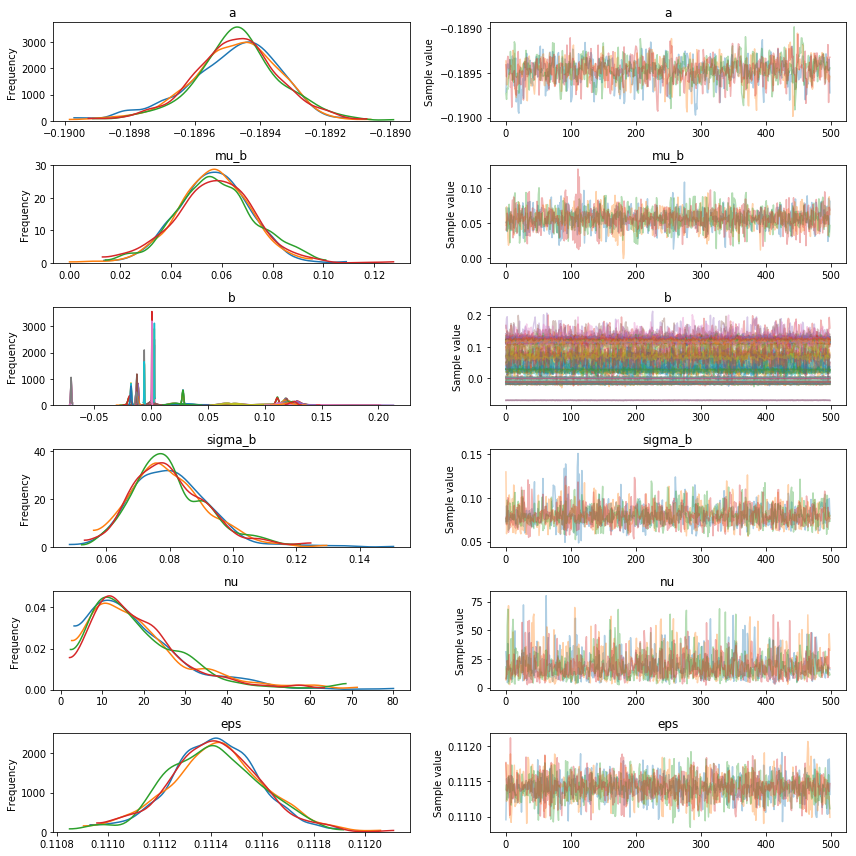

In [14]:
pm.traceplot(trace);

## Weights

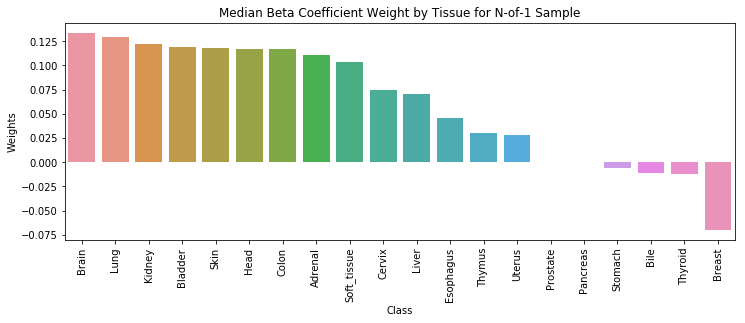

In [15]:
classes = normal.tissue.unique()
r.outlier.plot_weights(classes, trace)

## Gaussian Distribution 